
-----------

### **Backtesting Optimization**

❎ *' Version 1.3 '*

- In this Version We'll examine the our historical Back test Returns Over Time Across All the Assets that are Available Now.

  - ⚡The Current Workflow:

    - We Use **All** the **Assets** with the **Same Time Lines**.
    
    - For each Asset , We First Build a Portfolio that we put all the initial Investment **(1,000 $)** at the First of the Period to the End in Continiuous Compounding Way.
    
    - Based on the Historical Performances , We Construct a **Portfolio Matrix** With **All** the Asset Performance.
    
    - With having all the Historical Performance of the Assets Based On the Strategy , We Start To Build a Diversified Portfolio Based on the **Optimum Combinantion** of the ***Weights*** and ***Assets*** Where it Will **Maximize the Portfolio Cumulative Return**.
    
    - The Methods Are Used Within the Current Analysis are:

      - 🔍 Naive Asset Allocation
        - Equal Weight
        - Inverse Volatility

      - 🔍 Mean Variance Optimization
        - Pearson
        - Spearman

----------

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns

import math

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pd.options.display.float_format = '{:.2f}'.format

df = pd.read_csv(
    '/content/drive/MyDrive/ALGO-ROCK/Optimization (Razavi)/Total Backtest 12H.csv',
    parse_dates=['EntryTime', 'ExitDate']
).dropna(subset=['return'])

cols = ['slug','EntryTime', 'ExitDate', 'return']

df['EntryTime'] = df['EntryTime'].dt.strftime('%Y-%m-%d')
df['ExitDate'] = df['ExitDate'].dt.strftime('%Y-%m-%d')

return_df = pd.DataFrame(df,columns=cols)
return_df = (
    df[cols]
    .sort_values(by=['slug', 'EntryTime'])
    .reset_index(drop=True)
)
print('*'*50)
print(f"Assets Available: \n{return_df['slug'].unique()}\n")
print('*'*50)


**************************************************
Assets Available: 
['AAVE' 'ADA' 'APT' 'ARB' 'ATOM' 'AVAX' 'BCH' 'BNB' 'BTC' 'DOGE' 'DOT'
 'ETC' 'ETH' 'FDUSD' 'FET' 'FIL' 'FTM' 'HBAR' 'ICP' 'IMX' 'INJ' 'KAS'
 'LINK' 'LTC' 'NEAR' 'OP' 'PEPE' 'RENDER' 'RUNE' 'SHIB' 'SOL' 'STX' 'SUI'
 'TAO' 'TRX' 'UNI' 'VET' 'WIF' 'XLM' 'XMR' 'XRP']

**************************************************



-------
✅ **Asset Performance Backtest Analysis**
-------


1. We begin by creating a portfolio with an initial investment of $1,000 for each asset.

2. A separate portfolio is constructed for each individual asset, where the entire initial investment is allocated to that single asset.

3. For each asset's portfolio, we calculate the cumulative return at the end of the investment period, providing a detailed performance assessment for each asset individually.


--------

In [6]:

initial_capital = 1000

return_df['capital_before'] = 0.0
return_df['capital_after'] = 0.0

result = []
for slug, group in return_df.groupby('slug'):
    group = group.copy()
    current_capital = initial_capital

    for index, row in group.iterrows():
        group.at[index, 'capital_before'] = current_capital
        trade_return = row['return']
        current_capital = current_capital * (1 + trade_return)
        group.at[index, 'capital_after'] = current_capital
        group['cumulative_return'] = (group['capital_after'] / initial_capital) - 1

    result.append(group)

return_df = pd.concat(result, ignore_index=True)
return_df

,slug,EntryTime,ExitDate,return,capital_before,capital_after,cumulative_return
0,AAVE,2021-03-08,2021-03-11,-0.11,1000.00,893.62,-0.11
1,AAVE,2021-03-15,2021-03-31,-0.01,893.62,888.79,-0.11
2,AAVE,2021-04-02,2021-04-07,-0.09,888.79,809.68,-0.19
3,AAVE,2021-04-07,2021-04-12,-0.11,809.68,724.28,-0.28
4,AAVE,2021-04-12,2021-04-18,-0.14,724.28,622.07,-0.38
...,...,...,...,...,...,...,...
1954,XRP,2024-08-07,2024-08-27,-0.07,200.54,185.67,-0.81
1955,XRP,2024-09-05,2024-09-16,-0.05,185.67,176.54,-0.82
1956,XRP,2024-09-14,2024-09-17,-0.01,176.54,174.94,-0.83
1957,XRP,2024-09-18,2024-10-02,-0.06,174.94,164.46,-0.84


In [ ]:
portfolio_grouped = {}

start_date_global = pd.to_datetime(return_df['EntryTime']).min()
end_date_global = pd.to_datetime(return_df['ExitDate']).max()

date_range = pd.date_range(start=start_date_global, end=end_date_global, freq='D')

for slug, group in return_df.groupby('slug'):
    portfolio = pd.DataFrame(index=date_range)
    portfolio['daily_return'] = 0.0
    for index, row in group.iterrows():
        entry = pd.to_datetime(row['EntryTime'])
        exit = pd.to_datetime(row['ExitDate'])
        total_return = row['return']
        holding_days = (exit - entry).days + 1
        daily_return = total_return / holding_days

        portfolio.loc[entry:exit, 'daily_return'] += daily_return

    portfolio['daily_return'].copy().fillna(0, inplace=True)

    portfolio['portfolio_value'] = initial_capital * (1 + portfolio['daily_return']).cumprod()
    portfolio['cumulative_return'] = (portfolio['portfolio_value'] / initial_capital) - 1

    portfolio_grouped[slug] = portfolio


In [ ]:
# Building Base Portfolios

initial_capital = 1000

return_df['capital_before'] = 0.0
return_df['capital_after'] = 0.0

result = []
for slug, group in return_df.groupby('slug'):
    group = group.copy()
    current_capital = initial_capital

    for index, row in group.iterrows():
        group.at[index, 'capital_before'] = current_capital
        trade_return = row['return']
        current_capital = current_capital * (1 + trade_return)
        group.at[index, 'capital_after'] = current_capital
        group['cumulative_return'] = (group['capital_after'] / initial_capital) - 1

    result.append(group)

return_df = pd.concat(result, ignore_index=True)


# Asset Portfolio's Performance
portfolio_grouped = {}

start_date_global = pd.to_datetime(return_df['EntryTime']).min()
end_date_global = pd.to_datetime(return_df['ExitDate']).max()

date_range = pd.date_range(start=start_date_global, end=end_date_global, freq='D')

for slug, group in return_df.groupby('slug'):
    portfolio = pd.DataFrame(index=date_range)
    portfolio['daily_return'] = 0.0
    for index, row in group.iterrows():
        entry = pd.to_datetime(row['EntryTime'])
        exit = pd.to_datetime(row['ExitDate'])
        total_return = row['return']
        holding_days = (exit - entry).days + 1
        daily_return = total_return / holding_days

        portfolio.loc[entry:exit, 'daily_return'] += daily_return

    portfolio['daily_return'].copy().fillna(0, inplace=True)

    portfolio['portfolio_value'] = initial_capital * (1 + portfolio['daily_return']).cumprod()
    portfolio['cumulative_return'] = (portfolio['portfolio_value'] / initial_capital) - 1

    portfolio_grouped[slug] = portfolio

for slug, portfolio in portfolio_grouped.items():
    print(f"Portfolio for slug {slug}:")
    print(portfolio)
    print('*' * 50)



def ReturnMatrix(portfolio_grouped):
    matrix = {
        slug: portfolio['daily_return'] for slug, portfolio in portfolio_grouped.items()
    }
    return pd.DataFrame(matrix)
port_matrix = ReturnMatrix(portfolio_grouped)
port_matrix

Portfolio for slug AAVE:
            daily_return  portfolio_value  cumulative_return
2021-02-23          0.00          1000.00               0.00
2021-02-24          0.00          1000.00               0.00
2021-02-25          0.00          1000.00               0.00
2021-02-26          0.00          1000.00               0.00
2021-02-27          0.00          1000.00               0.00
...                  ...              ...                ...
2024-10-25          0.00          3918.60               2.92
2024-10-26          0.00          3918.60               2.92
2024-10-27          0.00          3918.60               2.92
2024-10-28          0.00          3918.60               2.92
2024-10-29          0.00          3918.60               2.92

[1345 rows x 3 columns]
**************************************************
Portfolio for slug ADA:
            daily_return  portfolio_value  cumulative_return
2021-02-23          0.00          1000.00               0.00
2021-02-24          0

,AAVE,ADA,APT,ARB,ATOM,AVAX,BCH,BNB,BTC,DOGE,...,STX,SUI,TAO,TRX,UNI,VET,WIF,XLM,XMR,XRP
2021-02-23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.13,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01
2021-02-24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.13,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01
2021-02-25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01
2021-02-26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01
2021-02-27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25,0.00,-0.00,0.01,0.00,-0.01,0.00,0.00,0.00,0.00,0.00,...,-0.02,-0.01,0.00,0.00,0.00,0.00,-0.01,0.00,0.00,0.00
2024-10-26,0.00,0.00,-0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2024-10-27,0.00,0.00,0.00,0.00,-0.01,0.00,0.00,0.00,0.00,0.00,...,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2024-10-28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# import pandas as pd
# from skfolio.moments import EmpiricalMu

# initial_capital = 1000

# return_df['capital_before'] = 0.0
# return_df['capital_after'] = 0.0

# result = []
# for slug, group in return_df.groupby('slug'):
#     group = group.copy()
#     current_capital = initial_capital

#     for index, row in group.iterrows():
#         group.at[index, 'capital_before'] = current_capital
#         trade_return = row['return']
#         current_capital = current_capital * (1 + trade_return)
#         group.at[index, 'capital_after'] = current_capital
#         group['cumulative_return'] = (group['capital_after'] / initial_capital) - 1

#     result.append(group)

# return_df = pd.concat(result, ignore_index=True)
# portfolio_grouped = {}

# start_date_global = pd.to_datetime(return_df['EntryTime']).min()
# end_date_global = pd.to_datetime(return_df['ExitDate']).max()

# date_range = pd.date_range(start=start_date_global, end=end_date_global, freq='D')

# for slug, group in return_df.groupby('slug'):
#     portfolio = pd.DataFrame(index=date_range)
#     portfolio['daily_return'] = 0.0
#     for index, row in group.iterrows():
#         entry = pd.to_datetime(row['EntryTime'])
#         exit = pd.to_datetime(row['ExitDate'])
#         total_return = row['return']
#         holding_days = (exit - entry).days + 1
#         daily_return = total_return / holding_days

#         portfolio.loc[entry:exit, 'daily_return'] += daily_return

#     portfolio['daily_return'].fillna(0, inplace=True)

#     portfolio['portfolio_value'] = initial_capital * (1 + portfolio['daily_return']).cumprod()
#     portfolio['cumulative_return'] = (portfolio['portfolio_value'] / initial_capital) - 1

#     portfolio_grouped[slug] = portfolio

# for slug, portfolio in portfolio_grouped.items():
#     print(f"Portfolio for slug {slug}:")
#     print(portfolio)
#     print('*' * 50)

# def ReturnMatrix(portfolio_grouped):
#     matrix = {
#         slug: portfolio['daily_return'] for slug, portfolio in portfolio_grouped.items()
#     }
#     return pd.DataFrame(matrix)

# port_matrix = ReturnMatrix(portfolio_grouped)

# # # Estimating Expected Returns using EmpiricalMu
# # empirical_mu = EmpiricalMu(window_size=None)  # Adjust window_size as needed
# # empirical_mu.fit(port_matrix)

# # expected_returns = empirical_mu.mu_
# # asset_names = empirical_mu.feature_names_in_

# # expected_returns_df = pd.DataFrame({
# #     'Asset': asset_names,
# #     'Expected Return': expected_returns
# # })

# # print("\nEstimated Expected Returns:")
# # print(expected_returns_df)


In [ ]:
# # Visualization
# def PlotAssetPerformace(portfolio_grouped, initial_capital, batch_size=2):
#     n_assets = len(portfolio_grouped.keys())
#     colors = colormaps.get_cmap('viridis')


#     n_batches = math.ceil(n_assets / batch_size)


#     for batch_idx in range(n_batches):
#         start_idx = batch_idx * batch_size
#         end_idx = min((batch_idx + 1) * batch_size, n_assets)


#         n_rows = end_idx - start_idx
#         fig, axes = plt.subplots(n_rows, 1, figsize=(18, 4 * n_rows), sharex=True)

#         if n_rows == 1:
#             axes = [axes]


#         for idx, (slug, portfolio) in enumerate(list(portfolio_grouped.items())[start_idx:end_idx]):
#             ax = axes[idx]
#             color = colors((start_idx + idx) / n_assets)

#             start_date = portfolio.index.min()
#             end_date = portfolio.index.max()
#             total_return = (portfolio['portfolio_value'].iloc[-1] / initial_capital) - 1
#             num_days = (end_date - start_date).days
#             annualized_return = (1 + total_return) ** (365 / num_days) - 1
#             portfolio['cum_max'] = portfolio['portfolio_value'].cummax()
#             portfolio['drawdown'] = (portfolio['portfolio_value'] - portfolio['cum_max']) / portfolio['cum_max']
#             max_drawdown = portfolio['drawdown'].min()
#             mean_daily_return = portfolio['daily_return'].mean()
#             std_daily_return = portfolio['daily_return'].std()
#             sharpe_ratio = (mean_daily_return / std_daily_return) * (365 ** 0.5)

#             ax.set_facecolor('#f0f0f0')
#             ax.plot(
#                 portfolio.index, portfolio['portfolio_value'],
#                 label=f'{slug} Portfolio Value', color=color
#             )

#             ax.set_title(f'{slug} Portfolio Value Over Time', fontsize=14)
#             ax.set_ylabel('Portfolio Value ($)', fontsize=12)
#             ax.grid(True)


#             final_value = portfolio['portfolio_value'].iloc[-1]
#             final_time = portfolio.index[-1]
#             ax.annotate(
#                 f'PortfolioValue:\n{final_value:,.2f} ($)',
#                 xy=(final_time, final_value),
#                 xytext=(10, 10),
#                 textcoords='offset points',
#                 fontsize=11,
#                 color='maroon',
#                 fontweight='bold',
#                 arrowprops=dict(arrowstyle='->', color=color)
#             )


#             metrics_text = (
#                 f"Start: {start_date}\n"
#                 f"End: {end_date}\n"
#                 f"Total Return: {total_return:.2%}\n"
#                 f"Annualized Return: {annualized_return:.2%}\n"
#                 f"Max Drawdown: {max_drawdown:.2%}\n"
#                 f"Sharpe Ratio: {sharpe_ratio:.2f}"
#             )
#             ax.text(0.01, 0.98, metrics_text, transform=ax.transAxes, fontsize=10,
#                     verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

#         axes[-1].set_xlabel('Date', fontsize=12)


#         plt.xticks(rotation=45)
#         plt.tight_layout()
#         plt.show()

# PlotAssetPerformace(portfolio_grouped, initial_capital=1000, batch_size=2)


-------
✅ **Portfolio (Strategy) Optimization**
-------

    🔴Maximizing Return With Optimized Weights🔴

-------


1. **⭕ Portfolio Return**:
   The portfolio return at time $t$ is given by:

   $$
   P_t = \sum_{i=1}^n w_i \cdot R_{t,i}
   $$

   Where:
   
   $
   w_i = [w_1, w_2, \dots, w_n]
   $
   represents the weights assigned to each asset.



2. **⭕ Cumulative Return**:

   The cumulative portfolio return over the entire period is:

   $$
   \text{Cumulative Return} = \prod_{t=1}^T (1 + P_t) - 1
   $$

-------

### **⚡ The Process of Optimization**
1. **Number of Assets**:
   - Let $n$ be the number of unique assets in the portfolio.
   - These assets are represented as:
     $$
     A = (A_1, A_2, \dots, A_n)
     $$

-------

2.  **Historical Time Periods**:
   - Let $T$ be the total number of historical periods for which data is available.

-------

3.  **Returns Matrix**:
   - The returns matrix  R  captures the historical returns of all assets across all time periods:
    $$
    R \in \mathbb{R}^{T \times n}
    $$

   Where:
   - $R_{t,i}$: The historical return of asset $A_i$ at time $t$.
   - Each **row** corresponds to a time period $t$.
   - Each **column** corresponds to an asset $A_i$.


   *The Returns Matrix $R$ can be represented as* : ⏬

   $$
   R =
   \begin{bmatrix}
   r_{1,1} & r_{1,2} & \cdots & r_{1,n} \\
   r_{2,1} & r_{2,2} & \cdots & r_{2,n} \\
   \vdots  & \vdots  & \ddots & \vdots  \\
   r_{T,1} & r_{T,2} & \cdots & r_{T,n}
   \end{bmatrix}
   $$

   *For Example* :

   $$
   R =
  \begin{bmatrix}
   r_{t1, \text{BTC}} & r_{t1, \text{ETH}} & r_{t1, \text{ADA}} \\
   r_{t2, \text{BTC}} & r_{t2, \text{ETH}} & r_{t2, \text{ADA}} \\
   r_{t3, \text{BTC}} & r_{t3, \text{ETH}} & r_{t3, \text{ADA}} \\
   r_{t4, \text{BTC}} & r_{t4, \text{ETH}} & r_{t4, \text{ADA}}
   \end{bmatrix}
   $$

   Where:
   - $r_{t1, \text{BTC}}$: Return of BTC at time $t1$.
   - $r_{t1, \text{ETH}}$: Return of ETH at time $t1$.
   - $r_{t1, \text{ADA}}$: Return of ADA at time $t1$.
   - Similarly, $t2$, $t3$, and $t4$ represent subsequent time periods.

  -------



-------

####  **🚩1. Naive Asset Allocation (Base Model)**



1.1  *Equal Weighted* :

  - Each asset weight is equal to **1/n Assets**


1.2  *InverseVolatility* :

  - Each asset weight is computed using the inverse of its volatility and rescaled to have a sum of weights equal to one. The assets volatilities are derived from the prior estimator’s covariance matrix.


------

In [ ]:
# ! pip install --upgrade skfolio

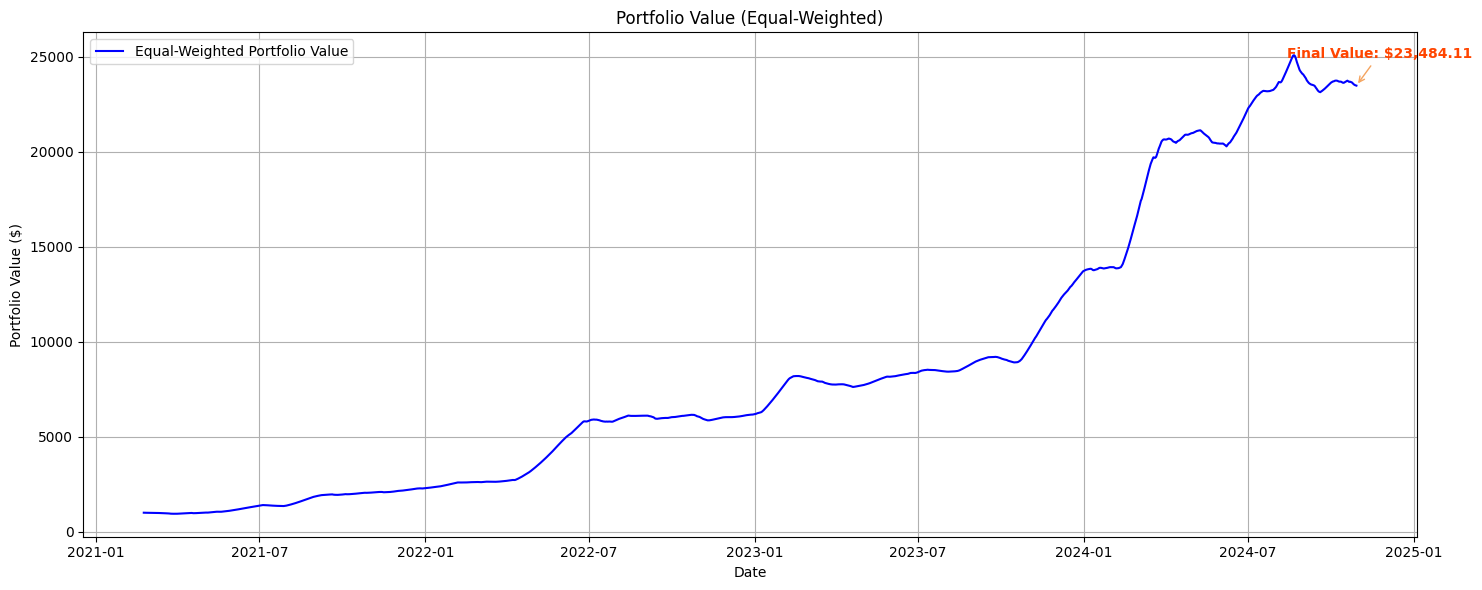

Equal Weights:
AAVE: 2.439%
ADA: 2.439%
APT: 2.439%
ARB: 2.439%
ATOM: 2.439%
AVAX: 2.439%
BCH: 2.439%
BNB: 2.439%
BTC: 2.439%
DOGE: 2.439%
DOT: 2.439%
ETC: 2.439%
ETH: 2.439%
FDUSD: 2.439%
FET: 2.439%
FIL: 2.439%
FTM: 2.439%
HBAR: 2.439%
ICP: 2.439%
IMX: 2.439%
INJ: 2.439%
KAS: 2.439%
LINK: 2.439%
LTC: 2.439%
NEAR: 2.439%
OP: 2.439%
PEPE: 2.439%
RENDER: 2.439%
RUNE: 2.439%
SHIB: 2.439%
SOL: 2.439%
STX: 2.439%
SUI: 2.439%
TAO: 2.439%
TRX: 2.439%
UNI: 2.439%
VET: 2.439%
WIF: 2.439%
XLM: 2.439%
XMR: 2.439%
XRP: 2.439%


In [ ]:
from skfolio.optimization import EqualWeighted

def ReturnMatrix(portfolio_grouped):
    matrix = {
        slug: portfolio['daily_return'] for slug, portfolio in portfolio_grouped.items()
    }
    return pd.DataFrame(matrix)
port_matrix = ReturnMatrix(portfolio_grouped)

equal_weighted_portfolio = EqualWeighted()
optimized_portfolio = equal_weighted_portfolio.fit(port_matrix)
weights = optimized_portfolio.weights_


initial_investment = 1000
portfolio_returns = port_matrix.dot(weights)
portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

plt.figure(figsize=(15, 6))
plt.plot(portfolio_value.index, portfolio_value, label="Equal-Weighted Portfolio Value", color='blue')

final_value = portfolio_value.iloc[-1]
final_date = portfolio_value.index[-1]

plt.annotate(
    f"Final Value: ${final_value:,.2f}",
    xy=(final_date, final_value),
    xytext=(-50, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color='sandybrown'),
    fontsize=10,
    color="orangered",
    fontweight='bold'
)


plt.title("Portfolio Value (Equal-Weighted)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

print("Equal Weights:")
for asset, weight in zip(port_matrix.columns, weights):
    print(f"{asset}: {weight:.3%}")

In [ ]:
# from skfolio import RiskMeasure
# from skfolio.optimization import InverseVolatility, MeanRisk, ObjectiveFunction
# from skfolio.portfolio import Portfolio
# import plotly.graph_objects as go


# mvo_model = MeanRisk(
#     risk_measure=RiskMeasure.STANDARD_DEVIATION,
#     objective_function=ObjectiveFunction.MAXIMIZE_RATIO
# )
# meanvar_model = mvo_model.fit(port_matrix)
# optimized_weights = pd.Series(meanvar_model.weights_, index=port_matrix.columns)
# portfolio_returns = port_matrix.dot(optimized_weights)

# initial_capital = 1000
# cumulative_returns = (1 + portfolio_returns).cumprod() - 1
# portfolio_value = initial_capital * (1 + cumulative_returns)


# fig = go.Figure()

# # Add Cumulative Returns
# fig.add_trace(go.Scatter(
#     x=cumulative_returns.index,
#     y=cumulative_returns.values,
#     mode='lines',
#     name='Cumulative Returns',
#     line=dict(color='blue')
# ))
# fig.update_layout(
#     title='Portfolio Performance: Cumulative Returns',
#     xaxis=dict(title='Date'),
#     yaxis=dict(title='Cumulative Returns', titlefont=dict(color='blue'), tickfont=dict(color='blue')),
#     yaxis2=dict(title='', titlefont=dict(color='red'), tickfont=dict(color='red'),
#                 overlaying='y', side='right'),
#     legend=dict(x=0.01, y=0.99),
#     width=1800,
#     height=550
# )

# fig.show()

-------

####  **🚩2. Mean Risk Optimization**


- To **Maximizing** the **Return** Over Specific Periods.


**🎯  Challenges**:

*The Following Parameters Must be Adjusted in a Optimized Way While Now We Put the Constraints Manually that can be caused of High Sensitivity of The Results By Changin the Pramaters*:

  1.  **Minimum Weights** : (1/Number Of Assets)
  2.  **Maximum Weights**
  
  ------

In [ ]:
from skfolio import RiskMeasure
from skfolio.optimization import MeanRisk, ObjectiveFunction
from skfolio.prior import EmpiricalPrior
from skfolio.moments import ShrunkMu
from skfolio.moments.covariance import BaseCovariance

# -------------------------------
# 2. Define Custom SpearmanCovariance Estimator
# -------------------------------

class SpearmanCovariance(BaseCovariance):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(self, X, y=None, **kwargs):
        """
        Fit the Spearman covariance estimator to the data.

        Parameters:
        - X: pd.DataFrame, asset returns with assets as columns and observations as rows.
        - y: Ignored. Included for compatibility.
        - kwargs: Additional keyword arguments.

        Returns:
        - self
        """
        # Calculate Spearman's rank correlation matrix
        spearman_corr, _ = spearmanr(X)
        spearman_corr = pd.DataFrame(spearman_corr, index=X.columns, columns=X.columns)

        # Calculate standard deviations
        std_devs = X.std()

        # Convert Spearman correlation to covariance matrix
        spearman_cov = spearman_corr * np.outer(std_devs, std_devs)
        spearman_cov = pd.DataFrame(spearman_cov, index=X.columns, columns=X.columns)

        # Assign to the covariance_ attribute
        self.covariance_ = spearman_cov

        return self

# -------------------------------
# 3. Initialize and Fit the MeanRisk Optimizer
# -------------------------------

# Instantiate the custom SpearmanCovariance estimator
spearman_cov_estimator = SpearmanCovariance()

# Initialize EmpiricalMu for mean estimation
mu_estimator = ShrunkMu()

# Initialize EmpiricalPrior with the custom covariance estimator
prior_estimator = EmpiricalPrior(
    mu_estimator=mu_estimator,
    covariance_estimator=spearman_cov_estimator
)

# Initialize the MeanRisk optimizer
mvo_model = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,  # Minimize variance to minimize risk
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,  # Maximize Sharpe Ratio
    prior_estimator=prior_estimator,
)

# Fit the optimizer to the data
meanvar_model = mvo_model.fit(port_matrix)

# Extract optimized weights
optimized_weights = pd.Series(meanvar_model.weights_, index=port_matrix.columns)
# -------------------------------
# 4. Calculate Portfolio Returns
# -------------------------------

# Calculate portfolio daily returns by applying optimized weights
portfolio_returns = port_matrix.dot(optimized_weights)
portfolio_returns.name = 'portfolio_return'

# -------------------------------
# 5. Calculate Portfolio Value Over Time
# -------------------------------

# Define the initial investment
initial_capital = 1000  # $1,000

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

# Calculate portfolio value over time
portfolio_value = initial_capital * (1 + cumulative_returns)

print("\nPortfolio Value Over Time:")
print(portfolio_value.tail())
# -------------------------------
# 6. Visualize the Portfolio Value
# -------------------------------

import plotly.graph_objects as go

# Create the plot using Plotly
fig = go.Figure()

# Add Portfolio Value trace
fig.add_trace(go.Scatter(
    x=portfolio_value.index,
    y=portfolio_value.values,
    mode='lines',
    name='Portfolio Value ($)',
    line=dict(color='blue'),
    hovertemplate=
        '<b>Date:</b> %{x}<br>' +
        '<b>Portfolio Value:</b> $%{y:,.2f}<extra></extra>'
))

# Update layout for the plot
fig.update_layout(
    title='Portfolio Performance: Mean-Variance Optimization using Spearman Covariance Matrix',
    xaxis=dict(title='Date'),
    yaxis=dict(
        title='Portfolio Value ($)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue')
    ),
    legend=dict(x=0.01, y=0.99),
    width=1200,
    height=600
)

# Show the plot
fig.show()




Portfolio Value Over Time:
2024-10-25   5192.38
2024-10-26   5187.43
2024-10-27   5186.87
2024-10-28   5186.66
2024-10-29   5186.01
Freq: D, Name: portfolio_return, dtype: float64


In [ ]:
print(optimized_weights)

AAVE     0.00
ADA      0.00
APT      0.03
ARB      0.00
ATOM     0.00
AVAX     0.00
BCH      0.00
BNB      0.00
BTC      0.00
DOGE     0.01
DOT      0.00
ETC      0.00
ETH      0.00
FDUSD    0.68
FET      0.02
FIL      0.00
FTM      0.01
HBAR     0.01
ICP      0.00
IMX      0.00
INJ      0.00
KAS      0.00
LINK     0.00
LTC      0.00
NEAR     0.00
OP       0.00
PEPE     0.01
RENDER   0.00
RUNE     0.03
SHIB     0.01
SOL      0.02
STX      0.00
SUI      0.05
TAO      0.00
TRX      0.04
UNI      0.00
VET      0.06
WIF      0.00
XLM      0.00
XMR      0.00
XRP      0.00
dtype: float64


In [ ]:
from sklearn import set_config
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from scipy.stats import loguniform

from skfolio import RatioMeasure, RiskMeasure
from skfolio.datasets import load_factors_dataset, load_sp500_dataset
from skfolio.model_selection import (
    CombinatorialPurgedCV,
    WalkForward,
    cross_val_predict,
)
from skfolio.moments import (
    DenoiseCovariance,
    DetoneCovariance,
    EWMu,
    GerberCovariance,
    ShrunkMu,
)
from skfolio.optimization import (
    MeanRisk,
    NestedClustersOptimization,
    ObjectiveFunction,
    RiskBudgeting,
)
from skfolio.pre_selection import SelectKExtremes
from skfolio.preprocessing import prices_to_returns
from skfolio.prior import BlackLitterman, EmpiricalPrior, FactorModel
from skfolio.uncertainty_set import BootstrapMuUncertaintySet



model = MeanRisk(
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    prior_estimator=EmpiricalPrior(
        mu_estimator=ShrunkMu(), covariance_estimator=DenoiseCovariance()
    ),
)


model.fit(port_matrix)
optimized_weights = pd.Series(model.weights_, index=port_matrix.columns)


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=portfolio_value.index,
    y=portfolio_value.values,
    mode='lines',
    name='Portfolio Value ($)',
    line=dict(color='blue'),
    hovertemplate=
        '<b>Date:</b> %{x}<br>' +
        '<b>Portfolio Value:</b> $%{y:,.2f}<extra></extra>'
))

fig.update_layout(
    title='Portfolio Performance: MeanVariance Optimization using "Spearman Covariance Matrix"',
    xaxis=dict(title='Date'),
    yaxis=dict(
        title='Portfolio Value ($)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue')
    ),
    legend=dict(x=0.01, y=0.99),
    width=1800,
    height=500
)
fig.show()
print("Optimized Portfolio Weights:")
print(optimized_weights)

Optimized Portfolio Weights:
AAVE     0.00
ADA      0.00
APT      0.02
ARB      0.04
ATOM     0.00
AVAX     0.00
BCH      0.00
BNB      0.00
BTC      0.00
DOGE     0.01
DOT      0.00
ETC      0.00
ETH      0.00
FDUSD    0.63
FET      0.01
FIL      0.01
FTM      0.02
HBAR     0.01
ICP      0.00
IMX      0.00
INJ      0.00
KAS      0.00
LINK     0.00
LTC      0.00
NEAR     0.00
OP       0.00
PEPE     0.01
RENDER   0.00
RUNE     0.03
SHIB     0.02
SOL      0.02
STX      0.00
SUI      0.05
TAO      0.03
TRX      0.03
UNI      0.00
VET      0.06
WIF      0.00
XLM      0.00
XMR      0.00
XRP      0.00
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from skfolio.moments.covariance import BaseCovariance
from skfolio import RiskMeasure
from skfolio.optimization import MeanRisk, ObjectiveFunction
from skfolio.portfolio import Portfolio
from skfolio.prior import EmpiricalPrior
from skfolio.moments import EmpiricalMu , EWMu
import plotly.graph_objects as go
from scipy.stats import spearmanr


# Building Base Portfolios

initial_capital = 1000

return_df['capital_before'] = 0.0
return_df['capital_after'] = 0.0

result = []
for slug, group in return_df.groupby('slug'):
    group = group.copy()
    current_capital = initial_capital

    for index, row in group.iterrows():
        group.at[index, 'capital_before'] = current_capital
        trade_return = row['return']
        current_capital = current_capital * (1 + trade_return)
        group.at[index, 'capital_after'] = current_capital
        group['cumulative_return'] = (group['capital_after'] / initial_capital) - 1

    result.append(group)

return_df = pd.concat(result, ignore_index=True)


# Asset Portfolio's Performance
portfolio_grouped = {}

start_date_global = pd.to_datetime(return_df['EntryTime']).min()
end_date_global = pd.to_datetime(return_df['ExitDate']).max()

date_range = pd.date_range(start=start_date_global, end=end_date_global, freq='D')

for slug, group in return_df.groupby('slug'):
    portfolio = pd.DataFrame(index=date_range)
    portfolio['daily_return'] = 0.0
    for index, row in group.iterrows():
        entry = pd.to_datetime(row['EntryTime'])
        exit = pd.to_datetime(row['ExitDate'])
        total_return = row['return']
        holding_days = (exit - entry).days + 1
        daily_return = total_return / holding_days

        portfolio.loc[entry:exit, 'daily_return'] += daily_return

    portfolio['daily_return'].copy().fillna(0, inplace=True)

    portfolio['portfolio_value'] = initial_capital * (1 + portfolio['daily_return']).cumprod()
    portfolio['cumulative_return'] = (portfolio['portfolio_value'] / initial_capital) - 1

    portfolio_grouped[slug] = portfolio


def ReturnMatrix(portfolio_grouped):
    matrix = {
        slug: portfolio['daily_return'] for slug, portfolio in portfolio_grouped.items()
    }
    return pd.DataFrame(matrix)
port_matrix = ReturnMatrix(portfolio_grouped)

class SpearmanCovariance(BaseCovariance):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def fit(self, X, y=None, **kwargs):
        spearman_corr, _ = spearmanr(X)
        spearman_corr = pd.DataFrame(spearman_corr, index=X.columns, columns=X.columns)
        std_devs = X.std()
        spearman_cov = spearman_corr * np.outer(std_devs, std_devs)
        spearman_cov = pd.DataFrame(spearman_cov, index=X.columns, columns=X.columns)
        self.covariance_ = spearman_cov
        return self
spearman_cov_estimator = SpearmanCovariance()
spearman_cov = spearman_cov_estimator.fit(port_matrix)

mu_estimator = EmpiricalMu()

prior_estimator = EmpiricalPrior(
    mu_estimator=mu_estimator,
    covariance_estimator=spearman_cov
)

mvo_model = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    min_weights=1/len(port_matrix.columns),
    max_weights=1,
    prior_estimator=prior_estimator,
)
meanvar_model = mvo_model.fit(port_matrix)
optimized_weights = pd.Series(meanvar_model.weights_, index=port_matrix.columns)

portfolio_returns = port_matrix.dot(optimized_weights)
portfolio_returns.name = 'portfolio_return'

initial_capital = 1000  # $1,000
cumulative_returns = (1 + portfolio_returns).cumprod() - 1
portfolio_value = initial_capital * (1 + cumulative_returns)


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=portfolio_value.index,
    y=portfolio_value.values,
    mode='lines',
    name='Portfolio Value ($)',
    line=dict(color='blue'),
    hovertemplate=
        '<b>Date:</b> %{x}<br>' +
        '<b>Portfolio Value:</b> $%{y:,.2f}<extra></extra>'
))

fig.update_layout(
    title='Portfolio Performance: MeanVariance Optimization using "Spearman Covariance Matrix"',
    xaxis=dict(title='Date'),
    yaxis=dict(
        title='Portfolio Value ($)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue')
    ),
    legend=dict(x=0.01, y=0.99),
    width=1800,
    height=500
)
fig.show()

print("Optimized Portfolio Weights:")
print(optimized_weights)

Optimized Portfolio Weights:
AAVE     0.02
ADA      0.02
APT      0.02
ARB      0.02
ATOM     0.02
AVAX     0.02
BCH      0.02
BNB      0.02
BTC      0.02
DOGE     0.02
DOT      0.02
ETC      0.02
ETH      0.02
FDUSD    0.02
FET      0.02
FIL      0.02
FTM      0.02
HBAR     0.02
ICP      0.02
IMX      0.02
INJ      0.02
KAS      0.02
LINK     0.02
LTC      0.02
NEAR     0.02
OP       0.02
PEPE     0.02
RENDER   0.02
RUNE     0.02
SHIB     0.02
SOL      0.02
STX      0.02
SUI      0.02
TAO      0.02
TRX      0.02
UNI      0.02
VET      0.02
WIF      0.02
XLM      0.02
XMR      0.02
XRP      0.02
dtype: float64


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Create a Function For Input/Output Model.* 🔴